<a href="https://colab.research.google.com/github/seonwoojh/Python_Tutorial/blob/master/LSTM_%ED%85%8C%EC%8A%AC%EB%9D%BC_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리
!pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf # yfinance 모듈을 이용하여 야후 파이낸스에서 제공하는 데이터에 접근
import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 6.4 MB 7.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# 데이터 셋 읽기
TSLA = yf.download('TSLA',
                   start = '2010-07-01',
                   end = '2021-12-16',
                   progress = False)

# 수정종가(Adj close), 시가(Open), 최고가(High), 최저가(Low), 종가(Close), 거래량(Volume)
col = ['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']

df = TSLA[col].round(2).reset_index()
df.head(5)

,Date,Adj Close,Open,High,Low,Close,Volume
0,2010-07-01,4.39,5.00,5.18,4.05,4.39,41094000
1,2010-07-02,3.84,4.60,4.62,3.74,3.84,25699000
2,2010-07-06,3.22,4.00,4.00,3.17,3.22,34334500
3,2010-07-07,3.16,3.28,3.33,3.00,3.16,34608500
4,2010-07-08,3.49,3.23,3.50,3.11,3.49,38557000


In [ ]:
df.tail(5)

,Date,Adj Close,Open,High,Low,Close,Volume
2881,2021-12-09,1003.80,1060.64,1062.49,1002.36,1003.80,19812800
2882,2021-12-10,1017.03,1008.75,1020.98,982.53,1017.03,19855000
2883,2021-12-13,966.41,1001.09,1005.00,951.42,966.41,26198500
2884,2021-12-14,958.51,945.00,966.41,930.00,958.51,23602100
2885,2021-12-15,975.99,953.21,978.75,928.25,975.99,25056400


In [ ]:
# 결측치 확인 / X
df.isna().sum()

Date         0
Adj Close    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

In [ ]:
# 기초통계량 확인
pd.options.display.float_format = '{:.2f}'.format
df[col].describe()

,Adj Close,Open,High,Low,Close,Volume
count,2886.00,2886.00,2886.00,2886.00,2886.00,2886.00
mean,120.04,119.96,122.49,117.26,120.04,31380546.05
std,220.12,219.96,224.68,214.80,220.12,28246720.53
min,3.16,3.23,3.33,3.00,3.16,592500.00
25%,17.09,16.51,17.70,15.93,17.09,12769950.00
50%,46.09,46.11,46.94,45.39,46.09,24851000.00
75%,66.61,66.47,67.58,65.29,66.61,40017750.00
max,1229.91,1234.41,1243.49,1217.00,1229.91,304694000.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2886 entries, 0 to 2885
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2886 non-null   datetime64[ns]
 1   Adj Close  2886 non-null   float64       
 2   Open       2886 non-null   float64       
 3   High       2886 non-null   float64       
 4   Low        2886 non-null   float64       
 5   Close      2886 non-null   float64       
 6   Volume     2886 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 158.0 KB


컬럼은 수정종가(Adj close), 시가(Open), 최고가(High), 최저가(Low), 종가(Close), 거래량(Volume)으로 구성되어 있습니다.

총 2886개의 row로 구성되어 있습니다.

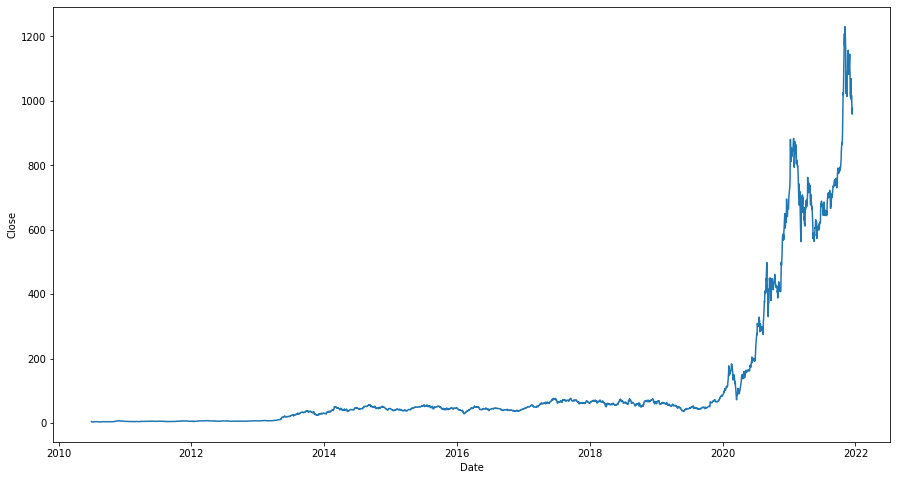

In [ ]:
# 주가 시각화
plt.figure(figsize = (15,8))
sns.lineplot(data = df, x = 'Date', y = 'Close')

In [ ]:
# 주가데이터 전처리 다시하기

from sklearn.preprocessing import MinMaxScaler
columns = ['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']

for col in columns:
    Scaler = MinMaxScaler()
    df[col] = Scaler.fit_transform(df[[col]])

# 잘 되었는지 확인
df[columns].describe()

,Adj Close,Open,High,Low,Close,Volume
count,2886.00,2886.00,2886.00,2886.00,2886.00,2886.00
mean,0.10,0.09,0.10,0.09,0.10,0.10
std,0.18,0.18,0.18,0.18,0.18,0.09
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.01,0.01,0.01,0.01,0.01,0.04
50%,0.03,0.03,0.04,0.03,0.03,0.08
75%,0.05,0.05,0.05,0.05,0.05,0.13
max,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
# 학습을 시킬 데이터 셋 생성
# window_size = 내가 일정기간동안 주가 데이터에 기반하여 다음날 종가를 예측할것인가?
# ex 과거 20일을 기반으로 내일 데이터를 예측한다 -> window_size = 20

Test_size = 200 # 과거 200일 이전의 데이터를 학습함 # 좀더 공부해서 조정하기 / 2020년까지의 데이터를 훈련용?
# 윈도우 사이즈 다양하게
train = df[:-Test_size].copy()
test = df[-Test_size:].copy()

In [ ]:
# 데이터 세트 함수 - window_size에 기반하여 지정한 기간의 데이터 셋 묶기
def datasets(data, label, window_size):
    feature_list = []
    target_list = []

    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i: i + window_size]))
        target_list.append(np.array(label.iloc[i + window_size]))
    return np.array(feature_list), np.array(target_list)

In [ ]:
feature_col = ['Open','High','Low','Volume']
target_col = ['Close']

train_feature = train[feature_col]
train_target = train[target_col]

# train 데이터 셋
train_feature, train_target = datasets(train_feature, train_target, 20)

# train, vaildation set 생성
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_feature, train_target,
                                                  test_size = 0.2, random_state = 24)

In [ ]:
# shape
X_train.shape, X_val.shape

((2132, 20, 4), (534, 20, 4))

In [ ]:
# 테스트 데이터 셋(실제 예측해볼 데이터)

test_feature = test[feature_col]
test_target = test[target_col]

test_feature, test_target = datasets(test_feature, test_target, 20)
test_feature.shape, test_target.shape

((180, 20, 4), (180, 1))

In [ ]:
# Keras LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False) # true
          )
model.add(Dense(1)) # 교재 참고

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(X_val, y_val))

Epoch 1/200
134/134 [==============================] - 12s 65ms/step - loss: 0.0057 - val_loss: 2.7298e-04
Epoch 2/200
134/134 [==============================] - 8s 62ms/step - loss: 2.4021e-04 - val_loss: 1.6738e-04
Epoch 3/200
134/134 [==============================] - 8s 62ms/step - loss: 1.6448e-04 - val_loss: 8.7248e-05
Epoch 4/200
134/134 [==============================] - 8s 62ms/step - loss: 1.1377e-04 - val_loss: 9.3008e-05
Epoch 5/200
134/134 [==============================] - 8s 62ms/step - loss: 1.0527e-04 - val_loss: 1.4278e-04
Epoch 6/200
134/134 [==============================] - 9s 64ms/step - loss: 1.0670e-04 - val_loss: 8.3904e-05
Epoch 7/200
134/134 [==============================] - 8s 61ms/step - loss: 9.8365e-05 - val_loss: 5.1094e-05
Epoch 8/200
134/134 [==============================] - 8s 62ms/step - loss: 7.5642e-05 - val_loss: 5.2568e-05
Epoch 9/200
134/134 [==============================] - 10s 76ms/step - loss: 7.4910e-05 - val_loss: 4.6468e-05
Epoch 10/200

In [ ]:
pred = model.predict(test_feature)

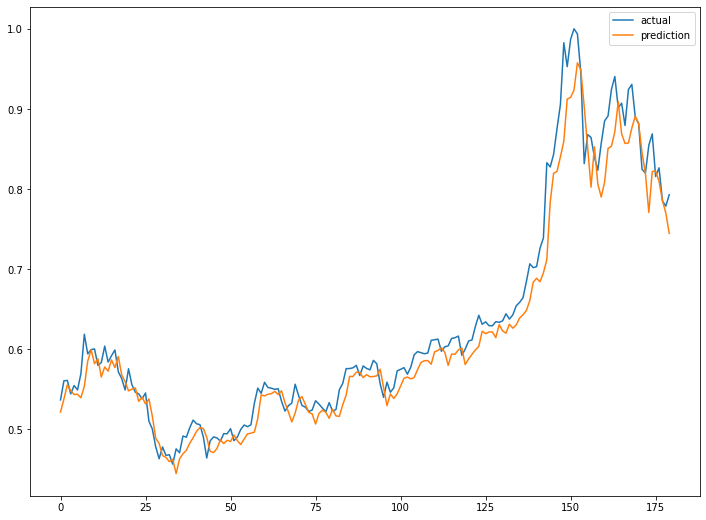

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()